# Stochastic Model for generating net demand process

Generating the net demand process which is **spatially** and **temporally** correlated using the (Gaussian) copula method with the following steps:
1. Generate process $x$: ARMA(1,1) model with a Gaussian error.
2. Convert process $x$ to uniform process $u$ by the corresponding (Gaussian) cdf.
3. Convert process $x$ to beta process $beta$ by Beta(a,b).
4. Convert process $beta$ to the net demand process $ND$ by shifting and scaling.

See my master thesis for the detail.

In [1]:
using DataFrames, CSV  # for reading datafiles 
using Distributions, StatsFuns  # for statistic functions
using Plots # for plotting
include("src/source.jl")
include("bound_data.jl");  # load data of the upper/lower bounds of net demand

### Node data

In [2]:
nodes_df = Read_nodes_csv("data/multilayer-nodes.csv")  # see src/source.jl
Nodes = nodes_df[:NodeID];

### Network data
* `n`: number of samples
* `d`: number of nodes
* `cov`: the covariance of multivariate Gaussian (denoted as $\rho$ in the thesis)
* `H`: number of time step 
* `NLayers`: number of layers

In [3]:
n = 5000; # num of samples
d = length(Nodes); 
cov = 0.6;  # covariance of the multivariate Gaussian
H =24; NLayers = 50;

### distribution data
* beta distribution: Beta(a,b) with a=b=6.
* ARMA(1,1) model $$x_t = \phi x_{t-1} + \epsilon_t + \theta \epsilon_{t-1}$$  with $\phi = 0.6, \theta = 0.8$.  
Note that $\epsilon_t$ follows $N(0,\Sigma)$ where $\Sigma$ is given by
$$
\Sigma = \begin{bmatrix}
   1       &\rho & \rho & \dots &\rho \\
   \rho       &1 & \rho & \dots & \rho \\
    \vdots \\ & & & \ddots &  \rho \\
    \rho       & \rho& \dots & \rho & 1
\end{bmatrix}
$$

In [4]:
# for beta distribution
a = 6;b = 6;
# for ARMA model
phi = 0.6; theta = 0.8;
SIGMA = ones(d,d)*cov + eye(d).*(1-cov);

## 1. Generate process $x$ 
$x$ follows copula & ARMA(1,1) model

In [5]:
Phi = phi*ones(d); Theta = theta*ones(d); # parameter for ARMA
x = zeros(H,d,n);
mvn = MvNormal(zeros(d),SIGMA);  # defnine multivariate normal
x[1,:,:] = rand(mvn, n);
err_prev = x[1,:,:];
for t = 2:H
    err = rand(mvn, n); # spacially dependent noise
    x[t,:,:] = Phi.*x[t-1,:,:] + err + Theta.*err_prev;
    err_prev = err;  # update the error term
end

See the dependence of process $x$

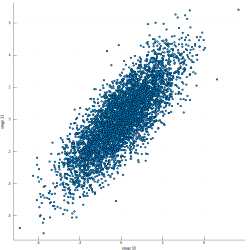

In [6]:
gr()
tt = 10; nn = 2;
scatter(x[tt,2,:], x[tt+1,2,:],leg=false, xaxis="stage 10", yaxis="stage 11", size=(1000,1000))

## 2. Convert $x$ to process $u$
Use the Gaussian cdf.   
First, we convert $x$ to the standard Gaussian by
$$
z_t = \frac{x_t-\mu_t}{\sigma_t}
$$
where $\mu_t$ is the mean and $\sigma_t$ is the standard deviation.   
Then, obtain the process $u$ by cdf of standard Gaussian `normcdf`.


In [7]:
x_mean = reshape(mean(x,3), Val{2});
x_std = reshape(std(x,3), Val{2});
z = (x.-x_mean)./x_std;  # obtain the standard normal distribution
clear!(:x);
u = normcdf.(z);  # convert by the cdf of standard normal
clear!(:z);

See the process $u$.  
Left panel: the histogram of u. Right panel: the scatter plot of u at node 2 and 3 at stage 10 (the corresponding distribution is called *copula*)

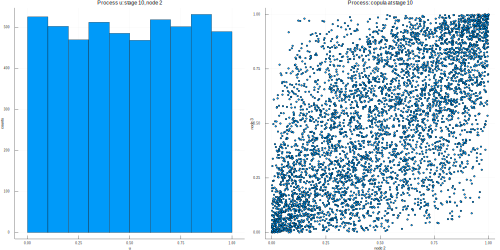

In [8]:
tt = 10; nn = 2;
plot(
    histogram(u[tt,nn,:],leg=false,xaxis="u",yaxis="counts",title="Process u: stage 10, node 2"),
    scatter(u[tt,2,:],u[tt,nn+1,:],leg=false,xaxis="node 2",yaxis="node 3",title="Process: copula at stage 10"),
    size=(2000,1000)
)

## 3. convert $u$ to process $beta$
Use Beta(6,6) function. *This computation takes some time.*

In [9]:
betadist = Beta(a, b); # define the beta distribution
@time betaval = quantile.(betadist, u);
clear!(:u);

 97.945477 seconds (91.93 k allocations: 525.747 MiB, 0.02% gc time)


## 4. convert $beta$ to the desired process $ND$ by shifting and scaling
We shift and scale the process $beta$ and obtain the net demand process which is spatially and temporally correlated.
$$
ND = beta * (UB - LB) + LB
$$
where $UB/LB$ is the upper and lower bound of the net demand.

In [10]:
ND = betaval.* (UB - LB) .+ LB;
clear!(:betaval);

See the process $ND$.  
Left panel: Net demand process over all stages with mean, LB and UB at node 2. Right panel: Histogram of net demand at node 2 at stage 10.

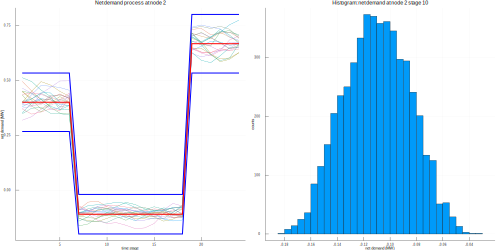

In [11]:
tt = 10; nn = 2;
plt1 = plot(ND[:,nn,1:20],leg=false,xaxis="time stage",yaxis="net demand (MW)",title="Net demand process at node 2");
plt1=  plot!(plt1,LB[:,nn],c=:blue,line=4);
plt1=  plot!(plt1,UB[:,nn],c=:blue,line=4);
plt1 = plot!(plt1,mean(ND[:,nn,:],2),c=:red,line=4);
plt2 =  histogram(ND[tt,nn,:], leg=false,xaxis="net demand (MW)",yaxis="counts",title="Histogram: net demand at node 2 stage 10");
plot(
   plt1,plt2,size=(2000,1000)
)